Attempt to build an LSTM network to solve the pose detection problem. DNN takes a lot of data. Currently we have about 3000 training data points, which is not quite ideal. Thus our goal is to evaluate the prospect of this network on pose detection via keypoints data with minimal feature engineering.


In [1]:
!nvidia-smi

Sat Dec 18 06:46:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import random
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
USE_CUDA = (
    torch.cuda.is_available()
)  
device = torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using {device}")

Using cuda


### Data Preprocessing
Load the data from csv and split them into train, dev, and test set. The labels are stored in txt files. Then since RNN models take a matrix, we need to define our sequence length (nrows) and feature size (ncols). We take a 100 frame as our sequenc length. We take all the keypoints data without the confidence level, so we have a feature size of 2*25 = 50. If the video results in more than 100 frames, it is trimmed, if fewer than 100 frames, it's pad with zeros. 
Thus every data point we have consistutes a matrix of size (100, 50). The labels are stored alongside the features. 
`label_encoder = {'lookaround':0, 'wavehand':1, 'playwithphone':2, 'phonecall':3}`

The data will be stored as a tensor (both the feature and the labels) on Google Drive

In [3]:
def data_loader(csv_full_path, txt_folder):
    """[summary]

    Args:
        csv_full_path (str): path to the csv file containing all the data
        txt_folder (str): path to the folder containing the txt file for train, dev, test split
    Returns: 
        3 pd.DataFrames; train, dev, test set
    """
    df = pd.read_csv(csv_full_path)

    with open(f"{txt_folder}/train.txt", "r") as f:
        folder_names = set(f.read().splitlines())
        print(f"data points in train set: {len(folder_names)}")
        df_train = df[df["folder_name"].isin(folder_names)]

    with open(f"{txt_folder}/dev.txt", "r") as f:
        folder_names = set(f.read().splitlines())
        print(f"data points in dev set: {len(folder_names)}")
        df_dev = df[df["folder_name"].isin(folder_names)]
        
    with open(f"{txt_folder}/test.txt", "r") as f:
        folder_names = set(f.read().splitlines())
        print(f"data points in test set: {len(folder_names)}")
        df_test = df[df["folder_name"].isin(folder_names)]

    return df_train, df_dev, df_test

def df_to_tensor(df):
    label_encoder = {'lookaround':0, 'wavehand':1, 'playwithphone':2, 'phonecall':3}
    
    cols = [f"x{i}" for i in range(25)] + [f"y{i}" for i in range(25)]
    names = df['folder_name'].unique()
    random.shuffle(names)
    data_lst = []
    label_lst = []

    for n in names:
        cur = df[df['folder_name'] == n].iloc[:100]
        cur = cur[cols]
        data_lst.append(torch.tensor(cur.values))
        label = n.split("_")[1]
        label_lst.append(label_encoder[label])
        
    X = nn.utils.rnn.pad_sequence(
        data_lst
        , batch_first=True
    )
    y = torch.tensor(label_lst)
    
        
    return X,y

### PyTorch Dataset

(I'm using PyTorch because I have recent LSTM code from HW to copy from.)

Construct a DataGenerator to load data in batches.

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [4]:
class PoseDataset(Dataset):
    def __init__(self, data):
        """
        Dataset class to help load and handle the data, specific to our format.
        Provides X, y pairs.
        """
        self.X = data['X']
        self.y = data['y']

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx, :]
        y = self.y[idx]

        return X, y

### Model 

Build an LSTM layer, then connect the final hidden state to a dense layer.

In [5]:
class LSTM_Network(nn.Module):
    def __init__(self, device):
        super(LSTM_Network, self).__init__()
        
        self.device = device
        self.num_layers = 2
        self.hidden_dim = 100
        self.rnn = nn.LSTM(
            input_size=50,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
        )
        self.dense1 = nn.Linear(self.hidden_dim, 4)

    def forward(self, x):
        x = x.to(self.device).type(torch.float32)
        h0 = (
            torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
            .requires_grad_()
            .to(self.device)
        )
        c0 = (
            torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
            .requires_grad_()
            .to(self.device)
        )
        out, (hidden_state, cell_state) = self.rnn(x, (h0, c0))
        out = self.dense1(hidden_state[-1])
        return out


### Full Pipeline

In [6]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/assistive_robot_dataset/csv/train_dev_test_split

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1d-Lf_YrIAO2cuhmL3nYF6MWqFgeNAJs8/assistive_robot_dataset/csv/train_dev_test_split


In [7]:
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.use_deterministic_algorithms(True)

%env CUBLAS_WORKSPACE_CONFIG=:16:8

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [8]:
# load data 
train, dev, test = torch.load("train.pt"), torch.load("dev.pt"), torch.load("test.pt")
# prepare data generator 
batch_size = 256
train_data = PoseDataset(train)
dev_data = PoseDataset(dev)
test_data = PoseDataset(test)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

train_generator = DataLoader(dataset=train_data, batch_size=batch_size, worker_init_fn=seed_worker, generator=g)
dev_generator = DataLoader(dataset=dev_data, batch_size=batch_size, worker_init_fn=seed_worker, generator=g)
test_generator = DataLoader(dataset=test_data, batch_size=batch_size, worker_init_fn=seed_worker, generator=g)

In [9]:
model = LSTM_Network(device).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
    step_size=1, gamma=0.99)
n_iter = 100
last_l_dev = None
for epoch in range(n_iter):
    for x, y in train_generator:
        y_pred = model(x)
        l = loss_fn(y_pred, y.to(device))
        l.backward()

        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()  # decay LR (if step_size hit)

    # require loss on the dev set
    l_dev = torch.zeros(1).to(device)
    for x, y in dev_generator:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        l_dev += loss_fn(y_pred, y.to(device))

    print(f"epoch: {epoch}; dev loss: {l_dev.item()}")

    # early stopping, should be more complicated than this
#     if last_l_dev is not None and last_l_dev.item() < l_dev.item():
#         break
    last_l_dev = l_dev

epoch: 0; dev loss: 2.1576833724975586
epoch: 1; dev loss: 1.7411589622497559
epoch: 2; dev loss: 1.557509183883667
epoch: 3; dev loss: 1.4490174055099487
epoch: 4; dev loss: 1.4750726222991943
epoch: 5; dev loss: 1.3837556838989258
epoch: 6; dev loss: 1.3502564430236816
epoch: 7; dev loss: 1.1648144721984863
epoch: 8; dev loss: 1.1493618488311768
epoch: 9; dev loss: 1.145907998085022
epoch: 10; dev loss: 1.0812417268753052
epoch: 11; dev loss: 1.43145751953125
epoch: 12; dev loss: 1.045413613319397
epoch: 13; dev loss: 1.0727161169052124
epoch: 14; dev loss: 0.9965035319328308
epoch: 15; dev loss: 0.9381787180900574
epoch: 16; dev loss: 0.926095724105835
epoch: 17; dev loss: 0.8789074420928955
epoch: 18; dev loss: 1.0383453369140625
epoch: 19; dev loss: 0.8640689849853516
epoch: 20; dev loss: 1.0989145040512085
epoch: 21; dev loss: 0.9050662517547607
epoch: 22; dev loss: 0.8425337076187134
epoch: 23; dev loss: 0.7823041677474976
epoch: 24; dev loss: 0.7428970336914062
epoch: 25; dev l

In [10]:
def test_model(model, loss_fn, test_generator):
    """
    Evaluate the performance of a model on the development set, providing the loss and macro F1 score.
    :param model: a model that performs 4-way emotion classification
    :param loss_fn: a function that can calculate loss between the predicted and gold labels
    :param test_generator: a DataLoader that provides batches of the testing set
    """
    gold = []
    predicted = []

    # Keep track of the loss
    loss = torch.zeros(1)  # requires_grad = False by default; float32 by default
    if USE_CUDA:
        loss = loss.cuda()

    model.eval()

    # Iterate over batches in the test dataset
    with torch.no_grad():
        for X_b, y_b in test_generator:
            # Predict
            y_pred = model(X_b)

            # Save gold and predicted labels for F1 score - take the argmax to convert to class labels
            gold.extend(y_b.cpu().detach().numpy())
            predicted.extend(y_pred.argmax(1).cpu().detach().numpy())

            loss += loss_fn(y_pred.double(), y_b.to(device)).data

    return gold, predicted, sum(np.array(gold) == np.array(predicted)) / len(predicted)

In [11]:
train_gold, train_pred, train_acc = test_model(model, loss_fn, train_generator)
dev_gold, dev_pred, dev_acc = test_model(model, loss_fn, dev_generator)
test_gold, test_pred, test_acc = test_model(model, loss_fn, test_generator)

In [12]:
# class_map = {'lookaround':0, 'wavehand':1, 'playwithphone':2, 'phonecall':3}
class_map = {0 : 0, 1 : 3, 2 : 2, 3 : 1}
for arr in [train_gold, train_pred, dev_gold, dev_pred, test_gold, test_pred]:
    arr[:] = [class_map[arr[i]] for i in range(len(arr))]

In [13]:
from sklearn.metrics import classification_report

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns

def generate_confusion_matrix(y_test, y_pred, labels, title):
  cf_matrix = confusion_matrix(y_test, y_pred)
  # sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
  x_axis_labels = labels
  y_axis_labels = labels
  sns.heatmap(cf_matrix, annot=True, cmap='Blues',xticklabels=x_axis_labels, yticklabels=y_axis_labels)

  plt.xticks(rotation=45) 
  plt.title(title, pad=10)
  plt.xlabel('Predicted Label', labelpad=10)
  plt.ylabel('True Label', labelpad=10)
  plt.show()

def generate_confusion_matrix_norm(y_test, y_pred, labels, title):
  cf_matrix = confusion_matrix(y_test, y_pred)
  x_axis_labels = labels
  y_axis_labels = labels

  col_sums = cf_matrix.sum(axis=1)
  norm_matrix = cf_matrix / col_sums[:,np.newaxis]
  sns.heatmap(norm_matrix, annot=True, fmt='.2%', cmap='Blues',xticklabels=x_axis_labels, yticklabels=y_axis_labels)

  plt.xticks(rotation=45) 
  plt.title(title, pad=10)
  plt.xlabel('Predicted Label', labelpad=10)
  plt.ylabel('True Label', labelpad=10)
  plt.show()

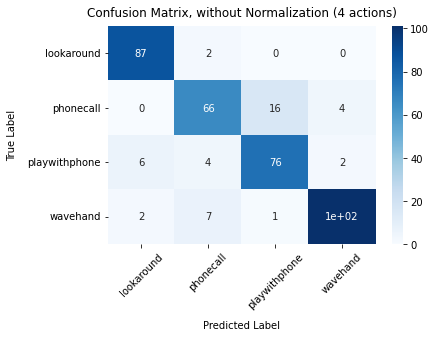

In [15]:
generate_confusion_matrix(test_gold, 
                          test_pred, 
                          ['lookaround', 'phonecall', 'playwithphone','wavehand'], 
                          'Confusion Matrix, without Normalization (4 actions)')

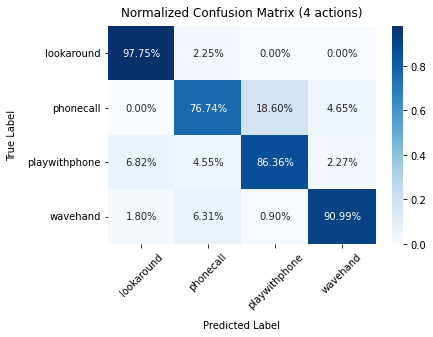

In [16]:
generate_confusion_matrix_norm(test_gold, 
                          test_pred, 
                          ['lookaround', 'phonecall', 'playwithphone','wavehand'], 
                          'Normalized Confusion Matrix (4 actions)')

In [17]:
y_test_categ = ['in need' if num in [0, 3] else 'not in need' for num in test_gold]
y_pred_categ = ['in need' if num in [0, 3] else 'not in need' for num in test_pred]

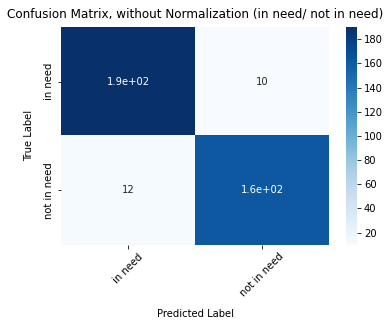

In [18]:
# confusion matrix for test set
generate_confusion_matrix(y_test_categ, 
                          y_pred_categ, 
                          ['in need', 'not in need'], 
                          'Confusion Matrix, without Normalization (in need/ not in need)')

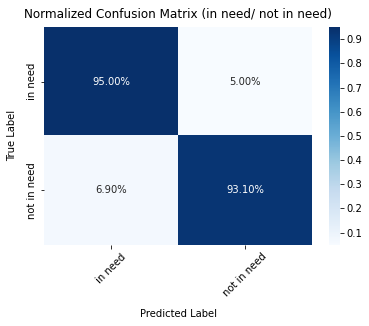

In [19]:
# confusion matrix for test set
generate_confusion_matrix_norm(y_test_categ, 
                          y_pred_categ, 
                          ['in need', 'not in need'], 
                          'Normalized Confusion Matrix (in need/ not in need)')

In [20]:
test_acc

0.8823529411764706

In [21]:
test_acc_categ = sum([a == b for a, b in zip(y_test_categ, y_pred_categ)]) / len(y_test_categ)
test_acc_categ

0.9411764705882353

In [22]:
print(classification_report(test_gold, test_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        89
           1       0.84      0.77      0.80        86
           2       0.82      0.86      0.84        88
           3       0.94      0.91      0.93       111

    accuracy                           0.88       374
   macro avg       0.88      0.88      0.88       374
weighted avg       0.88      0.88      0.88       374



In [23]:
print(classification_report(y_test_categ, y_pred_categ))

              precision    recall  f1-score   support

     in need       0.94      0.95      0.95       200
 not in need       0.94      0.93      0.94       174

    accuracy                           0.94       374
   macro avg       0.94      0.94      0.94       374
weighted avg       0.94      0.94      0.94       374

